In [1]:
import datetime
now = datetime.datetime.now()

# Sentiment Analysis

## Summer School JGU Mainz — Advanced Methods in Behavioral Economics, 2021

### Carina I. Hausladen

In [2]:
print(now.strftime("%Y-%m-%d"))

2021-10-01


In [3]:
import re
 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping

RANDOM_STATE = 42

# Sentiment Analysis
* Sentiment Analysis, or opinion mining, is a sub-field of NLP.
* It tries to identify and extract opinions within a given text.
* Sentiment Analysis can help to craft unstructured text into structured data using NLP and open source tools. 
* Approaches
    * Dictionary-based: 
        * Count the number of positive and negative words in the text; 
        * Define the difference between the number of positive and negative words as the sentiment of the text;
    * Deep learning, LSTM

## Data

* We use a Kaggle data set that contains annotated tweets from the first [US GOP Presidential Debate in 2016](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment). 
* You can find it in the data folder named `dataset_sentiment.csv`. 
* We only use the tweet and the human-labelled sentiment for this exercise.

In [4]:
df = pd.read_csv('data/dataset_sentiment.csv', usecols=['text','sentiment'])
df.head()

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


In [5]:
df["sentiment"].value_counts()

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

## Data preparation

### Basic preprocessing

In [6]:
max_features = 500

#df = df[df['sentiment'] != "Neutral"]  # drop rows with neutral sentiment
df['text'] = df['text'].apply(lambda x: x.lower()) # make everything lowervase
df['text'] = df['text'].apply(lambda x: x.replace('rt',' ')) # remove "RT" for "retweet"
df['text'] = df['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))  # remove special characters

### Tokenization

In [7]:
tok = Tokenizer(num_words=max_features, split=' ')
tok.fit_on_texts(df['text'].values)
X = tok.texts_to_sequences(df['text'].values)
X = pad_sequences(X)

### Create binary labels

In [8]:
y = pd.get_dummies(df['sentiment']).values

### Split data into train, validation, and test set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=RANDOM_STATE)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.25, random_state=RANDOM_STATE)

## LSTM
### Theory
[Santhosh Kumar](https://www.analyticsvidhya.com/blog/2021/06/natural-language-processing-sentiment-analysis-using-lstm/)

**RNN**
* An RNN (recurrent neural net) is a type of supervised deep learning algorithm.
* The idea behind RNN is to remember what information was there in the previous neurons.
* The information from a specific time instance ($t_1$) is used as an input for the next time instance ($t_2$).

<img src="figures/recurrent_cell.png" alt="mlp" width="500"/>

**Vanishing gradient** 
* In any neural network, the weights are updated in the training phase by calculating the error and back-propagation through the network. 
* In the case of an RNN, the gradient calculated at each time instance has to be multiplied back through the weights earlier in the network. 
* Therefore, for every time step we go back, for calculating the weights, the gradient becomes weaker.
* If the gradient value is very small, it won’t contribute much to the learning process.

**LSTM**
* LSTM (long short-term memory) is an updated version of an RNN to overcome the vanishing gradient problem.
* An LSTM has a memory cell at the top which helps to carry the information from a particular time instance to the next time instance in an efficient manner. 
* Information might be added or removed from the memory cell with the help of valves.

### Model definition
🤓: Understand and change the parameters for generating your lstm.

In [10]:
def create_binary_classification_lstm(input_shape,
                embed_dim=128,
                lstm_out=196,
                dropout = 0.1,
                dropout_1d=0.4,
                recurrent_dropout=0.1,
                print_summary=False
                ):
    nn = Sequential()
    nn.add(Embedding(max_features, embed_dim, input_length=input_shape))
    nn.add(SpatialDropout1D(dropout_1d))
    nn.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout))
    nn.add(Dense(3, activation='softmax'))  # shape 1 since we have a 1 dimensional output label
    nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_summary:
        print(nn.summary())
    return nn

### Model training and evaluation

* Neural Networks are incrementally trained in epochs. 
* Other ML models get one-time fitted to the data. 
* Training not long enough might lead to model "underfitting".
* Training for too long might cause "overfitting". 
* To find the sweet spot w.r.t. the number of epochs, we define an early stopping criterion:

🤓: Change the stopping rule. How does it impact performance?

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) # stop if validation loss does not increase for 5 epochs in a row

In [12]:
MAX_EPOCHS = 10 #0
BATCH_SIZE = 32

#train model
model = create_binary_classification_lstm(X.shape[1])
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=2, callbacks=[es])

2021-10-01 08:27:19.967783: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-01 08:27:20.298602: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
261/261 - 23s - loss: 0.8574 - accuracy: 0.6271 - val_loss: 0.7933 - val_accuracy: 0.6521
Epoch 2/10
261/261 - 17s - loss: 0.7568 - accuracy: 0.6687 - val_loss: 0.7601 - val_accuracy: 0.6662
Epoch 3/10
261/261 - 17s - loss: 0.7279 - accuracy: 0.6830 - val_loss: 0.7744 - val_accuracy: 0.6611
Epoch 4/10
261/261 - 13s - loss: 0.7139 - accuracy: 0.6915 - val_loss: 0.7869 - val_accuracy: 0.6651
Epoch 5/10
261/261 - 18s - loss: 0.7008 - accuracy: 0.6954 - val_loss: 0.7612 - val_accuracy: 0.6691
Epoch 6/10
261/261 - 17s - loss: 0.6870 - accuracy: 0.7021 - val_loss: 0.7733 - val_accuracy: 0.6680
Epoch 7/10
261/261 - 17s - loss: 0.6766 - accuracy: 0.7064 - val_loss: 0.7784 - val_accuracy: 0.6579
Epoch 00007: early stopping


### Loss history

If validation loss >> training loss you can call it overfitting.  
If validation loss  > training loss you can call it some overfitting.  
If validation loss  < training loss you can call it some underfitting.  
If validation loss << training loss you can call it underfitting. 

* Our aim is to make the validation loss as low as possible. 
* Some overfitting is nearly always a good thing. 
* All that matters in the end is: is the validation loss as low as you can get it.

🤓: Do we over- or underfit?

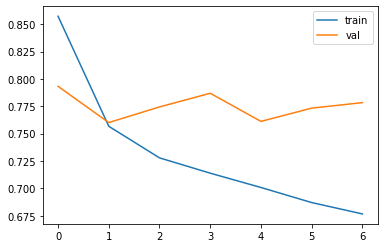

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

# Evaluate final classification metrics

In [14]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_validate, y_validate, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Final accuracies: Train: %.3f, Val: %.3f, Test: %.3f'  % (train_acc, val_acc, test_acc))

Final accuracies: Train: 0.727, Val: 0.658, Test: 0.664


# It's your turn! 🧑‍💻 ~7'